In [1]:
import geopandas as gpd

# 读取shp文件
file_path = r"E:\Crop\华北平原\NCC.shp"
try:
    gdf = gpd.read_file(file_path)
    
    # 1. 基本信息输出
    print("="*50)
    print(f"文件路径: {file_path}")
    print(f"几何类型: {gdf.geom_type.unique()}")
    print(f"要素数量: {len(gdf)}")
    print(f"坐标系: {gdf.crs}")
    
    # 2. 字段信息
    print("\n字段结构:")
    print(gdf.dtypes)
    
    # 3. 查看前3条样本数据（不包含几何列）
    print("\n前3条属性数据:")
    print(gdf.drop(columns='geometry').head(3))
    
    # 4. 空间范围
    print("\n空间范围:")
    print(gdf.total_bounds)

except Exception as e:
    print(f"读取文件时发生错误: {str(e)}")

文件路径: E:\Crop\华北平原\NCC.shp
几何类型: ['MultiPolygon' 'Polygon']
要素数量: 45
坐标系: EPSG:4326

字段结构:
地名             object
区划码            object
地级             object
地级码            object
地级类            object
省级             object
省级码            object
省级类            object
曾用名            object
备注             object
ENG_NAME       object
code           object
VAR_NAME       object
NAME_2         object
VAR_NAME2      object
GID_2          object
TYPE_2         object
NAME_1         object
VAR_NAME1      object
GID_1          object
TYPE_1         object
year           object
geometry     geometry
dtype: object

前3条属性数据:
    地名     区划码   地级     地级码  地级类   省级     省级码 省级类   曾用名    备注  ...  VAR_NAME  \
0  安阳市  410500  安阳市  410500  地级市  河南省  410000   省  None  None  ...   ān Yáng   
1  保定市  130600  保定市  130600  地级市  河北省  130000   省  None  None  ...  Bǎo Dìng   
2  滨州市  371600  滨州市  371600  地级市  山东省  370000   省  None  None  ...  Bīn Zhōu   

    NAME_2 VAR_NAME2   GID_2           TYPE_2    NAME_1  V

         地名     区划码   地级     地级码  地级类   省级     省级码 省级类  曾用名   备注  ...  NAME_2  \
count    45      45   45      45   45   45      45  45    0    0  ...      45   
unique   45      45   45      45    2    3       3   1    0    0  ...      45   
top     安阳市  410500  安阳市  410500  地级市  河南省  410000   省  NaN  NaN  ...  Anyang   
freq      1       1    1       1   44   18      18  45  NaN  NaN  ...       1   

       VAR_NAME2   GID_2           TYPE_2 NAME_1 VAR_NAME1   GID_1    TYPE_1  \
count         45      45               45     45        45      45        45   
unique        45      45                2      3         3       3         1   
top      ān Yáng  410500  Prefecture City  Henan    Hé Nán  410000  Province   
freq           1       1               44     18        18      18        45   

        year                                           geometry  
count     45                                                 45  
unique     1                                                 

<Axes: >

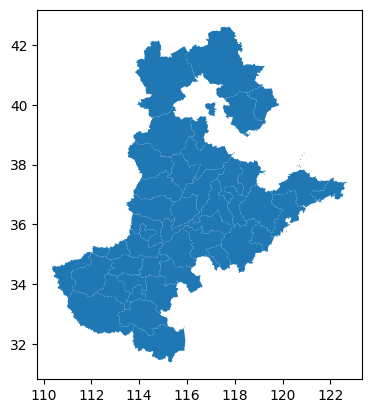

In [2]:
# 查看字段统计信息
print(gdf.describe())

# 绘制简单示意图（需要matplotlib）
gdf.plot()

In [ ]:
import pandas as pd

# 读取shp文件
gdf = gpd.read_file(file_path)

# 计算几何中心坐标（自动处理Polygon和MultiPolygon）
def get_centroid_coords(geom):
    centroid = geom.centroid
    return pd.Series({'centroid_x': centroid.x, 'centroid_y': centroid.y})

# 应用计算并合并结果
centroid_df = gdf['geometry'].apply(get_centroid_coords)
result_df = pd.concat([gdf.drop(columns='geometry'), centroid_df], axis=1)

# 保存为CSV（选择需要的列）
output_cols = ['地名', '区划码', '县级', '地级', '省级', 'centroid_x', 'centroid_y']
output_path = r"E:\Crop\华北平原\NCc_centroids.csv"
result_df[output_cols].to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"成功导出 {len(result_df)} 条记录的中心坐标到: {output_path}")
print("示例数据：")
print(result_df[output_cols].head(3))

成功导出 492 条记录的中心坐标到: E:\Crop\华北平原\NCc_centroids.csv
示例数据：
    地名     区划码   县级   地级   省级  centroid_x  centroid_y
0  安次区  131002  安次区  廊坊市  河北省  116.753265   39.341879
1  安国市  130683  安国市  保定市  河北省  115.322686   38.384703
2  安平县  131125  安平县  衡水市  河北省  115.478039   38.237451


In [ ]:
import json

# 构建树形字典
hierarchy = {}
for _, row in gdf.iterrows():
    province = row['省级']
    city = row['地级']
    county = {
        'name': row['县级'],
        'code': row['区划码'],
        'lon': row['lon'],
        'lat': row['lat'],
        'type': row['县级类']
    }
    
    if province not in hierarchy:
        hierarchy[province] = {}
    if city not in hierarchy[province]:
        hierarchy[province][city] = []
    hierarchy[province][city].append(county)

# 保存JSON
output_json = r"E:\Crop\华北平原\层级_树形.json"
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(hierarchy, f, ensure_ascii=False, indent=2)

print(f"树形JSON已保存到 {output_json}")

C:\Users\24658\AppData\Local\Temp\ipykernel_39976\317118477.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


层级JSON已保存到 E:\Crop\华北平原\hierarchy.json


In [9]:
# 1. 读取数据并计算正确经纬度
gdf = gpd.read_file(r"E:\Crop\华北平原\NCc.shp")
gdf_projected = gdf.to_crs("EPSG:32650")  # 转为投影坐标计算质心
gdf['geometry'] = gdf_projected['geometry'].centroid.to_crs("EPSG:4326")  # 转回WGS84
gdf['lon'] = gdf.geometry.x.round(6)  # 经度保留6位小数
gdf['lat'] = gdf.geometry.y.round(6)  # 纬度保留6位小数

# 2. 构建完整层级结构
gdf['省'] = gdf['省级']
gdf['市'] = gdf['地级']
gdf['县'] = gdf['县级']
gdf['层级路径'] = gdf['省'] + '→' + gdf['市'] + '→' + gdf['县']

# 3. 按层级排序并导出
gdf_sorted = gdf.sort_values(['省级码', '地级码', '区划码'])
output_cols = ['层级路径', '省', '市', '县', '区划码', 'lon', 'lat']
output_csv = r"E:\Crop\华北平原\NCc_centroids.csv"
gdf_sorted[output_cols].to_csv(output_csv, index=False, encoding='utf-8-sig')

In [ ]:
import geopandas as gpd

# 1. 读取数据并计算精确经纬度
gdf = gpd.read_file(r"E:\Crop\华北平原\NCc.shp")
gdf_projected = gdf.to_crs("EPSG:32650")  # 转为投影坐标计算质心
gdf['geometry'] = gdf_projected['geometry'].centroid.to_crs("EPSG:4326")  # 转回WGS84
gdf['lon'] = gdf.geometry.x.round(6)  # 经度保留6位小数
gdf['lat'] = gdf.geometry.y.round(6)  # 纬度保留6位小数

# 2. 按省级码→区划码排序（隐含层级关系）
gdf_sorted = gdf.sort_values(['省级码', '区划码'])

# 3. 导出指定字段
output_csv = r"E:\Crop\华北平原\locations_new.csv"

gdf_sorted.rename(columns={
    '省级码': 'province',
    '区划码': 'district'
})[['province', 'district', 'lon', 'lat']].to_csv(output_csv, index=False, encoding='utf-8-sig')
print("Export successful! File path:", output_csv)
print("\nSample data (sorted by hierarchy):")
# print(gdf_sorted[['province', 'district', 'lon', 'lat']].head(5))

Export successful! File path: E:\Crop\华北平原\locations_new.csv

Sample data (sorted by hierarchy):


KeyError: "['province', 'district'] not in index"